In [1]:
import cv2 
import numpy as np
import pickle
import matplotlib.pyplot as plt
import time


### Choose data

In [2]:

cifar = 2
data = cifar

In [ ]:
# Function to unpickle CIFAR data
def unpickle(file):
    with open(file, 'rb') as fo:
        data_dict = pickle.load(fo, encoding='bytes')
    return data_dict

if data == cifar :

    start_t = time.time()
    # Paths
    metadata_path = r'D:\Study\Uni_Projects\Machine Vision\Milestone-1\cifar-100\meta'  # Change this path
    data_pre_path = r"D:\Study\Uni_Projects\Machine Vision\Milestone-1\cifar-100\\"  # Change this path
    data_train_path = data_pre_path + 'train'
    data_test_path = data_pre_path + 'test'

    # Load metadata and superclass labels
    metadata = unpickle(metadata_path)
    superclass_dict = dict(enumerate(metadata[b'coarse_label_names']))

    # Load training and testing data
    data_train_dict = unpickle(data_train_path)
    data_test_dict = unpickle(data_test_path)

    # Extract training data
    cv_images = data_train_dict[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # Reshape to (N, H, W, C)
    labels = np.array(data_train_dict[b'fine_labels'])  # Use fine labels for 100 classes



    print(f"Data Loading Time: {time.time() - start_t:.2f} seconds")


    # Shape of data
    print(f"Training images shape: {cv_images.shape}")
    print(f"Training labels shape: {labels.shape}")




Data Loading Time: 2.67 seconds
Training images shape: (50000, 32, 32, 3)
Training labels shape: (50000,)


# feature extraction

In [4]:
from skimage.feature import hog , local_binary_pattern

# HOG 
def extract_hog(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    features, _ = hog(gray_image, orientations=9, pixels_per_cell=(8,8),
                      cells_per_block=(2, 2), block_norm='L2-Hys',
                      visualize=True, feature_vector=True)
    return features

# LBP 
def extract_lbp(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(gray_image, n_points, radius, method="uniform")
    
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), density=True)
    return lbp_hist

# Color 

def extract_color_hist(image):
    hist_red = cv2.calcHist([image], [0], None, [32], [0, 256])
    hist_green = cv2.calcHist([image], [1], None, [32], [0, 256])
    hist_blue = cv2.calcHist([image], [2], None, [32], [0, 256])
    color_hist = np.concatenate([hist_red, hist_green, hist_blue]).flatten()
    return color_hist / color_hist.sum()  # Normalize




hog_features = []
lbp_features = []
color_hist_features = []


start_t = time.time()


i = 1

for image in cv_images:
    if image is None:  # Skip invalid images
        continue
    # Resize the image to a fixed size for consistency

    image64 = cv2.resize(image, (64,64))
    image32 = cv2.resize(image, (32, 32))         # For 32x32 features
    
    # hog no difference 32 best speed 
    # color comparable at 32 , 64 no gain
    # lbp better at 64 no gain at 128 
    

    #64
    lbp_feat64 = extract_lbp(image64)
    
    #32
    hog_feat32 = extract_hog(image32)
    color_feat32 = extract_color_hist(image32)
    
    # Append to respective lists
    hog_features.append(hog_feat32)
    lbp_features.append(lbp_feat64)
    color_hist_features.append(color_feat32)
    
    
    if i % 500 == 0:
        print(f"Processed {i}/50000 of images")
    i += 1

# Convert to NumPy for further processing
hog_features = np.array(hog_features)
lbp_features = np.array(lbp_features)
color_hist_features = np.array(color_hist_features)


print(f"HOG features: {hog_features.shape}")
print(f"LBP features: {lbp_features.shape}")
print(f"Color Histogram features: {color_hist_features.shape}")

print(f"{time.time()-start_t} sec")
extraction_time = time.time()-start_t

Processed 500/50000 of images
Processed 1000/50000 of images
Processed 1500/50000 of images
Processed 2000/50000 of images
Processed 2500/50000 of images
Processed 3000/50000 of images
Processed 3500/50000 of images
Processed 4000/50000 of images
Processed 4500/50000 of images
Processed 5000/50000 of images
Processed 5500/50000 of images
Processed 6000/50000 of images
Processed 6500/50000 of images
Processed 7000/50000 of images
Processed 7500/50000 of images
Processed 8000/50000 of images
Processed 8500/50000 of images
Processed 9000/50000 of images
Processed 9500/50000 of images
Processed 10000/50000 of images
Processed 10500/50000 of images
Processed 11000/50000 of images
Processed 11500/50000 of images
Processed 12000/50000 of images
Processed 12500/50000 of images
Processed 13000/50000 of images
Processed 13500/50000 of images
Processed 14000/50000 of images
Processed 14500/50000 of images
Processed 15000/50000 of images
Processed 15500/50000 of images
Processed 16000/50000 of ima

In [5]:
print(f"HOG features: {hog_features.shape}")
print(f"LBP features: {lbp_features.shape}")
print(f"Color Histogram features: {color_hist_features.shape}")


HOG features: (50000, 324)
LBP features: (50000, 26)
Color Histogram features: (50000, 96)


# classifiers

In [6]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter



def knn_predict(train_features, train_labels, test_features, k=10, batches = 50):
    predictions = []
    num = len(test_features)
    batch_size = batches  # Process test samples in batches for better memory utilization
    num_batches = (num + batch_size - 1) // batch_size

    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, num)
        test_batch = test_features[start_idx:end_idx]
        
        distances = np.linalg.norm(train_features[:, None, :] - test_batch[None, :, :], axis=2)  # Shape: (train_size, batch_size)
        
        # Find nearest neighbors
        nearest_indices = np.argsort(distances, axis=0)[:k, :] 
        nearest_labels = train_labels[nearest_indices]  # Get the labels of the nearest neighbors
        
        # Determine the most common label for each test sample
        batch_predictions = [Counter(nearest_labels[:, col]).most_common(1)[0][0] for col in range(test_batch.shape[0])]
        predictions.extend(batch_predictions)
        
        print(f"Batch {batch_idx + 1}/{num_batches} completed")

    return np.array(predictions)



def train_svm(train_features, train_labels):
    svm = SVC(kernel="linear", C=1.0)
    svm.fit(train_features, train_labels)
    return svm




### K means with labelling

In [7]:
# kmean
def kmeans_clustering(features, num_clusters, max_iters=30, tol=1e-4):

    np.random.seed(40)
    centers = features[np.random.choice(features.shape[0], num_clusters, replace=False)]
    
    for i in range(max_iters):
        # Calculate distances and assign points to the nearest center
        distances = np.linalg.norm(features[:, np.newaxis] - centers, axis=2)
        cluster_labels = np.argmin(distances, axis=1)
        
        # Update centers
        new_centers = np.array([features[cluster_labels == k].mean(axis=0) for k in range(num_clusters)])
        if np.linalg.norm(new_centers - centers) < tol:
            break
        centers = new_centers
        
        print(f"step {i+1}")
    
    return centers


def assign_labels_to_clusters(centers, features, labels, k=500):

    cluster_labels = {}
    
    for idx, center in enumerate(centers):
        # Compute distances to all features
        distances = np.linalg.norm(features - center, axis=1)
        nearest_points = np.argsort(distances)[:k]
        nearest_labels = labels[nearest_points]
        
        most_common_label = Counter(nearest_labels).most_common(1)[0][0]
        cluster_labels[idx] = most_common_label
    
    return cluster_labels


def predict_using_kmeans(centers, cluster_labels, test_features):

    predictions = []
    
    for test_sample in test_features:
        # Find the nearest center
        distances = np.linalg.norm(centers - test_sample, axis=1)
        nearest_center_idx = np.argmin(distances)
        
        # Use the label of the nearest center
        predictions.append(cluster_labels[nearest_center_idx])
    
    return np.array(predictions)


# train

In [8]:

hog_features_array = np.array(hog_features)
lbp_features_array = np.array(lbp_features)
color_hist_features_array = np.array(color_hist_features)



labels_array = np.array(labels)

# Split Data into Training and Testing

X_train_hog, X_test_hog, y_train_hog, y_test_hog = train_test_split(hog_features_array, labels_array, test_size=0.2, random_state=42)
X_train_lbp, X_test_lbp, y_train_lbp, y_test_lbp= train_test_split(lbp_features_array, labels_array, test_size=0.2, random_state=42)
X_train_color, X_test_color, y_train_color , y_test_color = train_test_split(color_hist_features_array, labels_array, test_size=0.2, random_state=42)





### HOG

In [9]:
#  KNN
print("Training K-Nearest Neighbors for hog...")
start_time = time.time()
knn_predictions_hog = knn_predict(X_train_hog, y_train_hog, X_test_hog, k=10 , batches = 10)
knn_accuracy_hog = accuracy_score(y_test_color, knn_predictions_hog)
print(f"K-Nearest Neighbors (hog) Accuracy: {knn_accuracy_hog}, taking: {time.time() - start_time} sec")
knn_hog_time = time.time() - start_time


# svm
print("Training SVM...")
start_time = time.time()
svm_model_hog = train_svm(X_train_hog, y_train_hog)
svm_predictions_hog = svm_model_hog.predict(X_test_hog)
svm_accuracy_hog = accuracy_score(y_test_hog, svm_predictions_hog)
print(f"SVM (HOG) Accuracy: {svm_accuracy_hog}, takiing: {time.time()-start_time} sec")
svm_hog_time = time.time() - start_time


Training K-Nearest Neighbors for hog...
Batch 1/1000 completed
Batch 2/1000 completed
Batch 3/1000 completed
Batch 4/1000 completed
Batch 5/1000 completed
Batch 6/1000 completed
Batch 7/1000 completed
Batch 8/1000 completed
Batch 9/1000 completed
Batch 10/1000 completed
Batch 11/1000 completed
Batch 12/1000 completed
Batch 13/1000 completed
Batch 14/1000 completed
Batch 15/1000 completed
Batch 16/1000 completed
Batch 17/1000 completed
Batch 18/1000 completed
Batch 19/1000 completed
Batch 20/1000 completed
Batch 21/1000 completed
Batch 22/1000 completed
Batch 23/1000 completed
Batch 24/1000 completed
Batch 25/1000 completed
Batch 26/1000 completed
Batch 27/1000 completed
Batch 28/1000 completed
Batch 29/1000 completed
Batch 30/1000 completed
Batch 31/1000 completed
Batch 32/1000 completed
Batch 33/1000 completed
Batch 34/1000 completed
Batch 35/1000 completed
Batch 36/1000 completed
Batch 37/1000 completed
Batch 38/1000 completed
Batch 39/1000 completed
Batch 40/1000 completed
Batch 41/

### Color hist

In [10]:


#  KNN
print("Training K-Nearest Neighbors for color...")
start_time = time.time()
knn_predictions_color = knn_predict(X_train_color, y_train_color, X_test_color, k=10)
knn_accuracy_color = accuracy_score(y_test_color, knn_predictions_color)
print(f"K-Nearest Neighbors (color) Accuracy: {knn_accuracy_color}, taking: {time.time() - start_time} sec")
knn_color_time = time.time() - start_time

# SVM
print("Training SVM for color...")
start_time = time.time()
svm_model_color = train_svm(X_train_color, y_train_color)
svm_predictions_color = svm_model_color.predict(X_test_color)
svm_accuracy_color= accuracy_score(y_test_color, svm_predictions_color)
print(f"SVM (color) Accuracy: {svm_accuracy_color}, taking: {time.time() - start_time} sec")
svm_color_time = time.time() - start_time


Training K-Nearest Neighbors for color...
Batch 1/200 completed
Batch 2/200 completed
Batch 3/200 completed
Batch 4/200 completed
Batch 5/200 completed
Batch 6/200 completed
Batch 7/200 completed
Batch 8/200 completed
Batch 9/200 completed
Batch 10/200 completed
Batch 11/200 completed
Batch 12/200 completed
Batch 13/200 completed
Batch 14/200 completed
Batch 15/200 completed
Batch 16/200 completed
Batch 17/200 completed
Batch 18/200 completed
Batch 19/200 completed
Batch 20/200 completed
Batch 21/200 completed
Batch 22/200 completed
Batch 23/200 completed
Batch 24/200 completed
Batch 25/200 completed
Batch 26/200 completed
Batch 27/200 completed
Batch 28/200 completed
Batch 29/200 completed
Batch 30/200 completed
Batch 31/200 completed
Batch 32/200 completed
Batch 33/200 completed
Batch 34/200 completed
Batch 35/200 completed
Batch 36/200 completed
Batch 37/200 completed
Batch 38/200 completed
Batch 39/200 completed
Batch 40/200 completed
Batch 41/200 completed
Batch 42/200 completed
B

### kmean with color


In [11]:
num_clusters = len(np.unique(labels_array))
start_time = time.time()
# Train K-Means without labels
centers = kmeans_clustering(X_train_color, num_clusters)
cluster_labels = assign_labels_to_clusters(centers, X_train_color, y_train_color, k=500)
kmeans_predictions = predict_using_kmeans(centers, cluster_labels, X_test_color)
kmeans_accuracy = accuracy_score(y_test_color, kmeans_predictions)
print(f"K-Means Accuracy: {kmeans_accuracy}")

kmeans_color_time = time.time() - start_time


step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29
step 30
K-Means Accuracy: 0.047


### LBP

In [12]:
# K-Nearest Neighbors
print("Training K-Nearest Neighbors for LBP...")
start_time = time.time()
knn_predictions_lbp = knn_predict(X_train_lbp, y_train_lbp, X_test_lbp, k=10)
knn_accuracy_lbp = accuracy_score(y_test_lbp, knn_predictions_lbp)
print(f"K-Nearest Neighbors (LBP) Accuracy: {knn_accuracy_lbp}, taking: {time.time() - start_time} sec")
knn_lbp_time = time.time() - start_time



# Support Vector Machine (SVM)
print("Training SVM for LBP...")
start_time = time.time()
svm_model_lbp = train_svm(X_train_lbp, y_train_lbp)
svm_predictions_lbp = svm_model_lbp.predict(X_test_lbp)
svm_accuracy_lbp = accuracy_score(y_test_lbp, svm_predictions_lbp)
print(f"SVM (LBP) Accuracy: {svm_accuracy_lbp}, taking: {time.time() - start_time} sec")
svm_lbp_time = time.time() - start_time


Training K-Nearest Neighbors for LBP...
Batch 1/200 completed
Batch 2/200 completed
Batch 3/200 completed
Batch 4/200 completed
Batch 5/200 completed
Batch 6/200 completed
Batch 7/200 completed
Batch 8/200 completed
Batch 9/200 completed
Batch 10/200 completed
Batch 11/200 completed
Batch 12/200 completed
Batch 13/200 completed
Batch 14/200 completed
Batch 15/200 completed
Batch 16/200 completed
Batch 17/200 completed
Batch 18/200 completed
Batch 19/200 completed
Batch 20/200 completed
Batch 21/200 completed
Batch 22/200 completed
Batch 23/200 completed
Batch 24/200 completed
Batch 25/200 completed
Batch 26/200 completed
Batch 27/200 completed
Batch 28/200 completed
Batch 29/200 completed
Batch 30/200 completed
Batch 31/200 completed
Batch 32/200 completed
Batch 33/200 completed
Batch 34/200 completed
Batch 35/200 completed
Batch 36/200 completed
Batch 37/200 completed
Batch 38/200 completed
Batch 39/200 completed
Batch 40/200 completed
Batch 41/200 completed
Batch 42/200 completed
Bat

#### LBP kmean

In [13]:

# Train K-Means without labels
start_time = time.time()
centers = kmeans_clustering(X_train_lbp, num_clusters,max_iters=60)
cluster_labels = assign_labels_to_clusters(centers, X_train_lbp, y_train_lbp, k=500)
kmeans_predictions = predict_using_kmeans(centers, cluster_labels, X_test_lbp)
kmeans_accuracy_lbp = accuracy_score(y_test_lbp, kmeans_predictions)
print(f"K-Means Accuracy: {kmeans_accuracy_lbp}")

kmeans_lbp_time = time.time() - start_time

step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29
step 30
step 31
step 32
step 33
step 34
step 35
step 36
step 37
step 38
step 39
step 40
step 41
step 42
step 43
step 44
step 45
step 46
step 47
step 48
step 49
step 50
step 51
step 52
step 53
step 54
step 55
step 56
step 57
step 58
step 59
step 60
K-Means Accuracy: 0.0462


In [ ]:

with open("Final_results.txt", "a") as f:
    f.write("\n-----------------------\n")
    f.write(f"dataset: {data}\n")
    f.write(f"parameters -> max_iter = 30, extraction_time: {extraction_time} \n")
    
    f.write(f"svm_hog_32 acc: {svm_accuracy_hog * 100:.2f}% time: {svm_hog_time:.2f} sec\n")
    f.write(f"kmean_hog_32 acc: {knn_accuracy_hog * 100:.2f}% time: {knn_hog_time:.2f} sec\n")
    
    f.write("\n")
    f.write(f"svm_lbp acc: {svm_accuracy_lbp * 100:.2f}% time: {svm_lbp_time:.2f} sec \n")
    f.write(f"knn_lbp acc: {knn_accuracy_lbp * 100:.2f}% time: {knn_lbp_time:.2f} sec\n")
    f.write(f"kmean_lbp acc: {kmeans_accuracy_lbp * 100:.2f}% time: {kmeans_lbp_time:.2f} sec\n")
    
    f.write("\n")
    f.write(f"svm_color acc: {svm_accuracy_color * 100:.2f}% time: {svm_color_time:.2f} sec\n")
    f.write(f"knn_color acc: {knn_accuracy_color * 100:.2f}% time: {knn_color_time:.2f} sec \n")
    f.write(f"kmean_color acc: {kmeans_accuracy * 100:.2f}% time: {kmeans_color_time:.2f} sec \n")
    
    


## Confusion matrix


### HOG

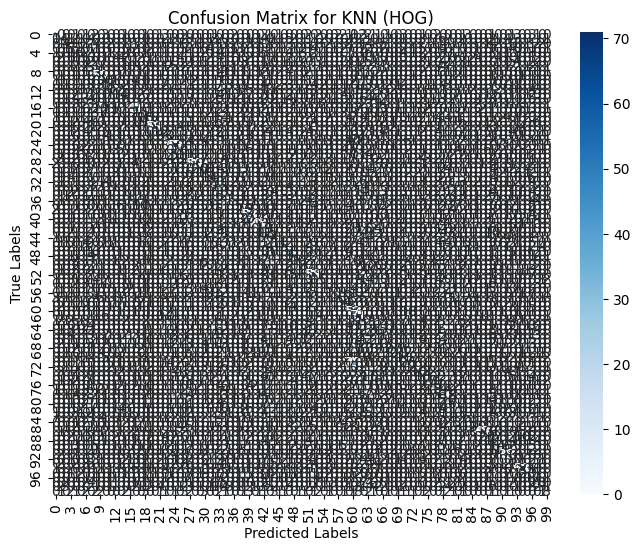

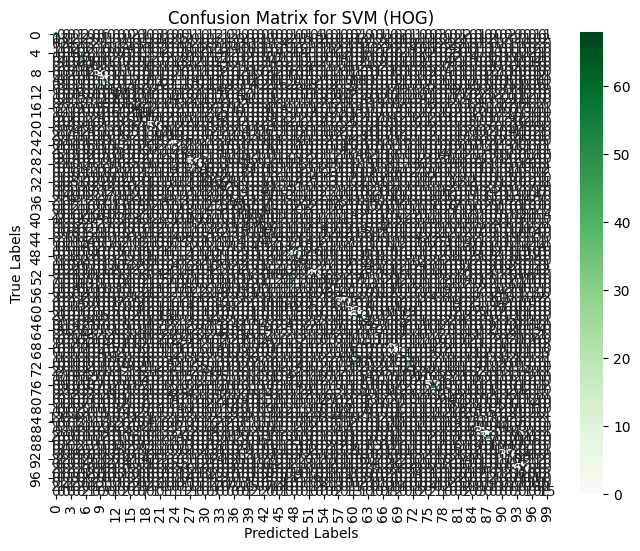

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Generate and visualize confusion matrix for KNN (HOG)
knn_conf_matrix_hog = confusion_matrix(y_test_hog, knn_predictions_hog)
plt.figure(figsize=(8, 6))
sns.heatmap(knn_conf_matrix_hog, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for KNN (HOG)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Generate and visualize confusion matrix for SVM (HOG)
svm_conf_matrix_hog = confusion_matrix(y_test_hog, svm_predictions_hog)
plt.figure(figsize=(8, 6))
sns.heatmap(svm_conf_matrix_hog, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix for SVM (HOG)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


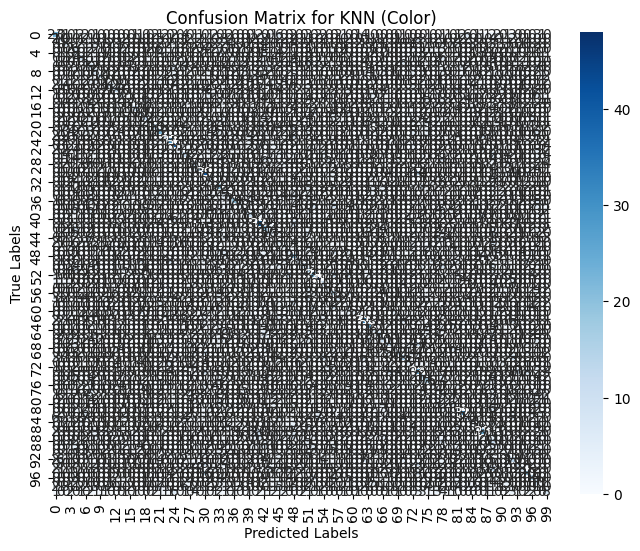

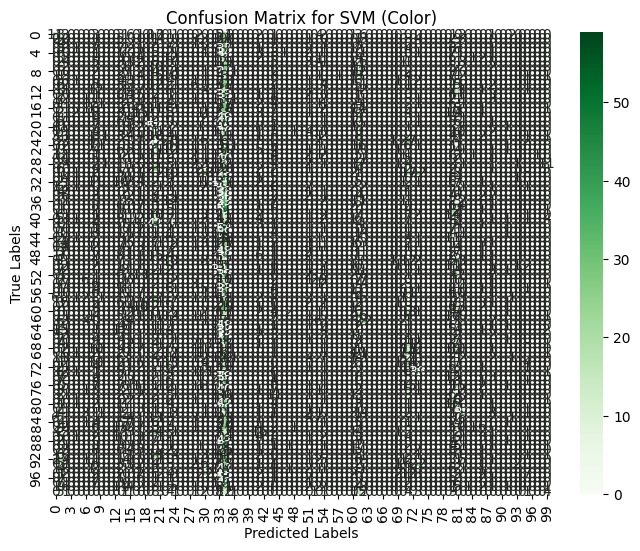

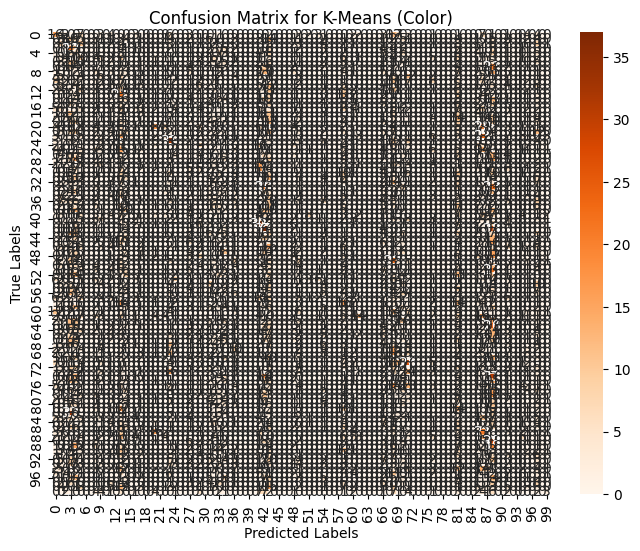

In [16]:
# Generate and visualize confusion matrix for KNN (color)
knn_conf_matrix_color = confusion_matrix(y_test_color, knn_predictions_color)
plt.figure(figsize=(8, 6))
sns.heatmap(knn_conf_matrix_color, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for KNN (Color)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Generate and visualize confusion matrix for SVM (color)
svm_conf_matrix_color = confusion_matrix(y_test_color, svm_predictions_color)
plt.figure(figsize=(8, 6))
sns.heatmap(svm_conf_matrix_color, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix for SVM (Color)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Generate and visualize confusion matrix for K-Means (color)
kmeans_conf_matrix_color = confusion_matrix(y_test_color, kmeans_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(kmeans_conf_matrix_color, annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix for K-Means (Color)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


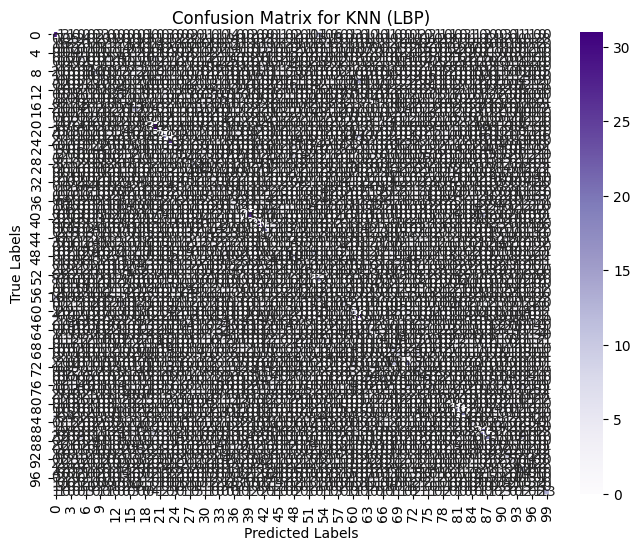

(100, 100)


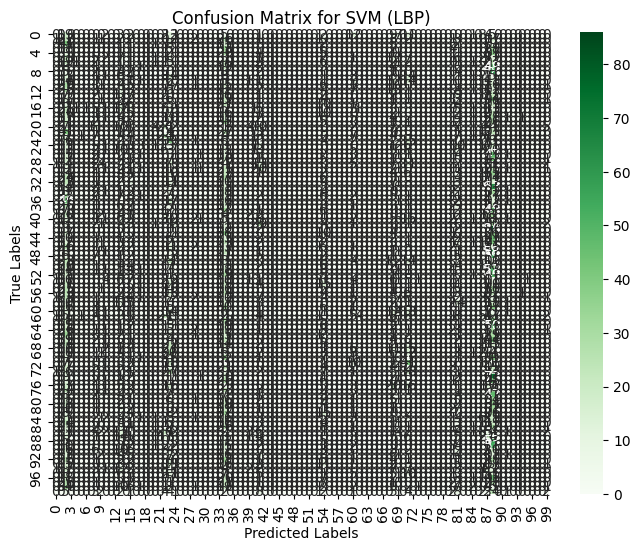

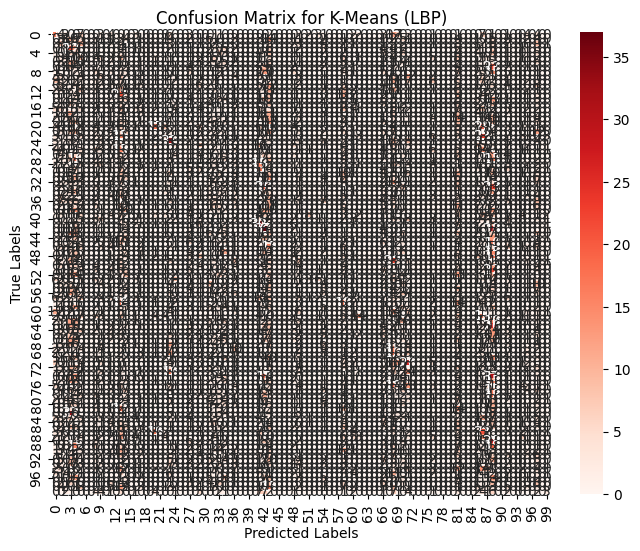

In [34]:

# Generate and visualize confusion matrix for KNN (LBP)
knn_conf_matrix_lbp = confusion_matrix(y_test_lbp, knn_predictions_lbp)
print(knn_conf_matrix_lbp.shape)
plt.figure(figsize=(8, 6))
sns.heatmap(knn_conf_matrix_lbp, annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix for KNN (LBP)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Generate and visualize confusion matrix for SVM (LBP)
svm_conf_matrix_lbp = confusion_matrix(y_test_lbp, svm_predictions_lbp)
print(svm_conf_matrix_lbp.shape)
plt.figure(figsize=(8, 6))
sns.heatmap(svm_conf_matrix_lbp, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix for SVM (LBP)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Generate and visualize confusion matrix for K-Means (LBP)
kmeans_conf_matrix_lbp = confusion_matrix(y_test_lbp, kmeans_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(kmeans_conf_matrix_lbp, annot=True, fmt='d', cmap='Reds')
plt.title("Confusion Matrix for K-Means (LBP)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


## 10 predictions with each classifer shown on terminal

In [20]:
from collections import Counter
import numpy as np

def knn_predict_an_image(train_features, train_labels, test_feature, k=10):

    distances = np.linalg.norm(train_features - test_feature, axis=1)  # Compute distances
    nearest_indices = np.argsort(distances)[:k]  # Indices of k-nearest neighbors
    nearest_labels = train_labels[nearest_indices]  # Get the labels of nearest neighbors
    most_common_label = Counter(nearest_labels).most_common(1)[0][0]  # Most frequent label
    return most_common_label


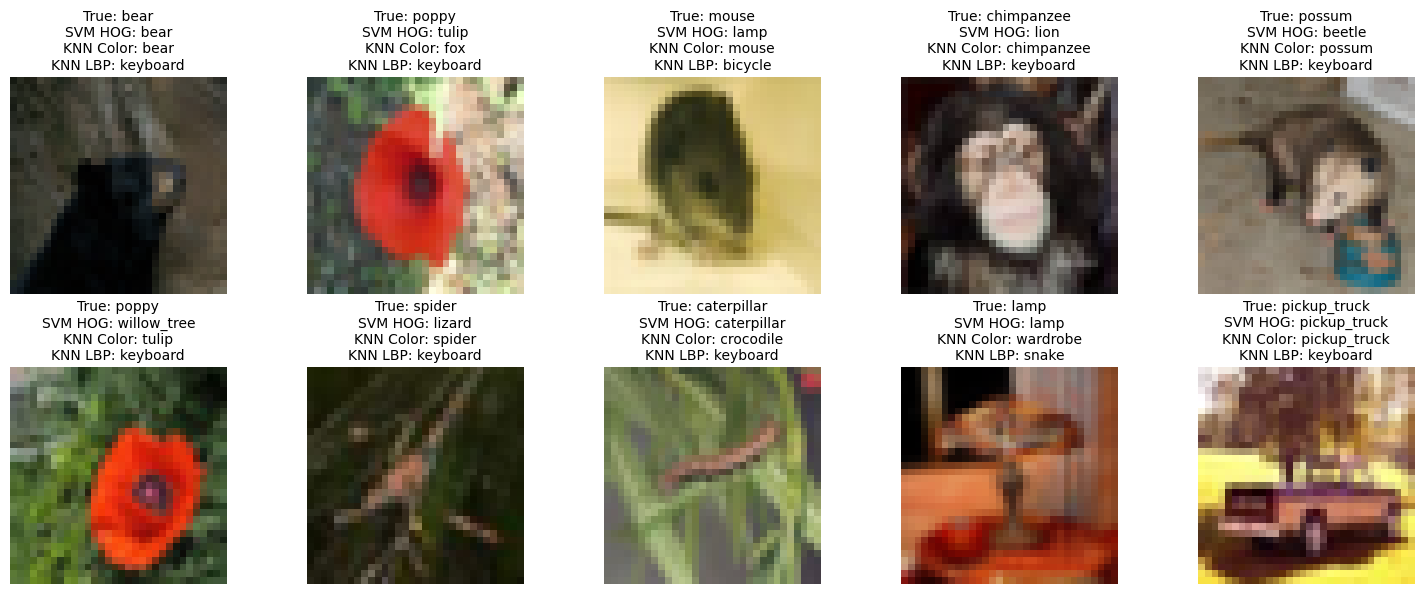

In [ ]:
import random
import matplotlib.pyplot as plt


random.seed(42)
random_indices = random.sample(range(len(cv_images)), 10)

fine_label_names = metadata[b'fine_label_names']
label_name_mapping = {i: fine_label_names[i].decode('utf-8') for i in range(len(fine_label_names))}

# plot
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # Create  grid 
axes = axes.ravel()  

for i, idx in enumerate(random_indices):

    image = cv_images[idx]
    true_label = labels_array[idx]  

    # Extract features for the image
    hog_feat = extract_hog(image)
    color_feat = extract_color_hist(image)
    lbp_feat = extract_lbp(image)

    # Ensure features are properly passed for prediction
    svm_hog_pred = svm_model_hog.predict([hog_feat])[0]  # SVM requires 2D array as input
    knn_color_pred = knn_predict_an_image(X_train_color, y_train_color, color_feat, k=10)  # Predict using color
    knn_lbp_pred = knn_predict_an_image(X_train_lbp, y_train_lbp, lbp_feat, k=10)  # Predict using LBP

    # Display the image
    axes[i].imshow(image, cmap="gray")  
    axes[i].axis("off")

    axes[i].set_title(
        f"True: {label_name_mapping[true_label]}\n"
        f"SVM HOG: {label_name_mapping[svm_hog_pred]}\n"
        f"KNN Color: {label_name_mapping[knn_color_pred]}\n"
        f"KNN LBP: {label_name_mapping[knn_lbp_pred]}",
        fontsize=10,
    )


plt.tight_layout()
plt.show()
